In [1]:
import netCDF4 as nc4
import keras
import xarray,numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import  Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils
from tensorflow.keras import layers

# Read data

In [2]:
file_path =['C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_01.nc']
ds = nc4.MFDataset(file_path)
eta_t = ds.variables['eta_t'][:]
eta_t_numpy = np.array(eta_t)
eta_t_numpy = np.nan_to_num(eta_t_numpy)
eta_t_numpy.shape

(31, 1500, 3600)

In [3]:
input_data = eta_t_numpy[0,:,:]
input_data.shape

(1500, 3600)

In [5]:
input_data[0]

array([-32768., -32768., -32768., ..., -32768., -32768., -32768.],
      dtype=float32)

# fixed missing values with 0

In [6]:
for i in range(0,len(input_data)):
    arr = input_data[i]
    arr[arr == -32768] = 0

In [7]:
input_data[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

# Normalize the input

In [8]:
def normalize_matrix(matrix):
    norm = np.linalg.norm(matrix)
    print(norm)
    matrix = matrix/norm  # normalized matrix
    return matrix

normalize_matrix(input_data)
input_data

1476.3408


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.82399976, -0.82399976, -0.79348123, ..., -0.82399976,
        -0.82399976, -0.82399976],
       [-0.82399976, -0.79348123, -0.79348123, ..., -0.82399976,
        -0.82399976, -0.82399976],
       [-0.76296276, -0.76296276, -0.7324442 , ..., -0.76296276,
        -0.76296276, -0.76296276]], dtype=float32)

In [9]:
input_data[-40]

array([-0.82399976, -0.82399976, -0.82399976, ..., -0.82399976,
       -0.82399976, -0.82399976], dtype=float32)

# Split array into 128*128

In [10]:
import math
lat = 128
long = 128

pad_rows = math.ceil(3600/lat)*lat - 3600
pad_cols = math.ceil(1500/long)*long - 1500
print(pad_rows)
print(pad_cols)

112
36


In [11]:
input_data=np.pad(input_data,((0,pad_cols),(0,pad_rows)), 'constant',constant_values=(0,0))

In [12]:
input_data.shape

(1536, 3712)

In [13]:
l = np.array_split(input_data,len(input_data)/lat,axis=0)
input_data_split = []
for i in range(len(l)):
    dd = np.array_split(l[i],29,axis=1)
    input_data_split += dd
input_data_split = np.array(input_data_split)

In [14]:
input_data_split.shape

(348, 128, 128)

# split train set & validation set

In [15]:
train_set, test_set = train_test_split(input_data_split, test_size=0.33)
train_set.shape

(233, 128, 128)

# Autoencoder

In [21]:
input_img = keras.Input(shape=(128, 128,1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu',strides=(1,1))(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same',strides=(2,2))(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((4, 4))(x)
decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 62, 62, 8)         1160      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 4)         292       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 4)           0   

In [17]:
history = autoencoder.fit(train_set, train_set,
                epochs=100, validation_data=(test_set, test_set))

Epoch 1/100
8/8 [==============================] - 4s 455ms/step - loss: 0.7793 - val_loss: 0.7028
Epoch 2/100
8/8 [==============================] - 2s 213ms/step - loss: 0.6413 - val_loss: 0.6183
Epoch 3/100
8/8 [==============================] - 2s 211ms/step - loss: 0.6782 - val_loss: 0.4512
Epoch 4/100
8/8 [==============================] - 2s 219ms/step - loss: 0.4993 - val_loss: 0.3588
Epoch 5/100
8/8 [==============================] - 2s 211ms/step - loss: 0.3561 - val_loss: 0.3425
Epoch 6/100
8/8 [==============================] - 2s 219ms/step - loss: 0.3569 - val_loss: 0.3374
Epoch 7/100
8/8 [==============================] - 2s 222ms/step - loss: 0.3838 - val_loss: 0.3337
Epoch 8/100
8/8 [==============================] - 2s 217ms/step - loss: 0.4009 - val_loss: 0.3296
Epoch 9/100
8/8 [==============================] - 2s 208ms/step - loss: 0.4027 - val_loss: 0.3276
Epoch 10/100
8/8 [==============================] - 2s 211ms/step - loss: 0.3324 - val_loss: 0.3264
Epoch 11/

8/8 [==============================] - 2s 209ms/step - loss: 0.3342 - val_loss: 0.3156
Epoch 84/100
8/8 [==============================] - 2s 219ms/step - loss: 0.3408 - val_loss: 0.3156
Epoch 85/100
8/8 [==============================] - 2s 217ms/step - loss: 0.3165 - val_loss: 0.3156
Epoch 86/100
8/8 [==============================] - 2s 208ms/step - loss: 0.2730 - val_loss: 0.3155
Epoch 87/100
8/8 [==============================] - 2s 208ms/step - loss: 0.3259 - val_loss: 0.3155
Epoch 88/100
8/8 [==============================] - 2s 216ms/step - loss: 0.3447 - val_loss: 0.3155
Epoch 89/100
8/8 [==============================] - 2s 215ms/step - loss: 0.3182 - val_loss: 0.3155
Epoch 90/100
8/8 [==============================] - 2s 232ms/step - loss: 0.3664 - val_loss: 0.3155
Epoch 91/100
8/8 [==============================] - 2s 221ms/step - loss: 0.3461 - val_loss: 0.3155
Epoch 92/100
8/8 [==============================] - 2s 225ms/step - loss: 0.3189 - val_loss: 0.3155
Epoch 93/100


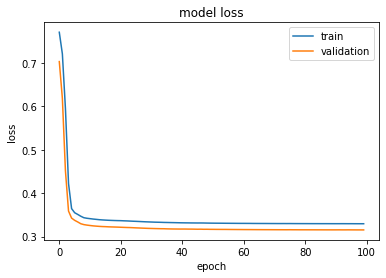

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [27]:
history.history

{'loss': [0.7703978419303894,
  0.72064608335495,
  0.5943832993507385,
  0.42237594723701477,
  0.3643995523452759,
  0.35493093729019165,
  0.3509906232357025,
  0.3468085825443268,
  0.34341123700141907,
  0.34215274453163147,
  0.3412726819515228,
  0.34036287665367126,
  0.3396472930908203,
  0.3388787806034088,
  0.3383549153804779,
  0.337918758392334,
  0.33753693103790283,
  0.33724743127822876,
  0.3369881510734558,
  0.33677926659584045,
  0.33663445711135864,
  0.3362920880317688,
  0.33605101704597473,
  0.33570027351379395,
  0.3353535532951355,
  0.3350801169872284,
  0.3347380459308624,
  0.33437153697013855,
  0.33404114842414856,
  0.3337630331516266,
  0.3335002064704895,
  0.33321160078048706,
  0.33302581310272217,
  0.33286967873573303,
  0.3325968086719513,
  0.3324756324291229,
  0.3323030173778534,
  0.33215010166168213,
  0.3320082128047943,
  0.33182647824287415,
  0.33170145750045776,
  0.3315967917442322,
  0.33152836561203003,
  0.3314192295074463,
  0.331